In [8]:
# OBJECTIVE BUILD HISTOGRAM AND STATISTiCS FOR PROCESSES BY MILESTONES
import numpy as np
import pandas as pd
import util
import matplotlib.pyplot as plt


df = pd.read_csv('Without incomplete cases-BPI Challenge 2017 2.csv', delimiter=';', encoding='utf-8-sig')

keepcolumns  =  ['Case ID','Activity','Start Timestamp']

origactivity  = ['A_Pending','A_Cancelled','A_Denied']
aliasactivity = ['Pending','Cancelled','Denied']
# MILESTONE 1: Completing the application
milestone_1_start  = ['A_Create Application']
milestone_1_finish = ['A_Accepted']
milestone_1_leak   = []
milestone_1 = milestone_1_start + milestone_1_finish + milestone_1_leak

# MILESTONE 2: Issuing orders & Validating Applications
# From A_Accepted the order might have been (1) A_Cancelled, (2) A_Denied, (3) O_Returned
# look for cancelled and denied that never reached (3) O_Returned

milestone_2_start    = ['A_Accepted']
milestone_2_finish   = ['O_Returned']
milestone_2_leak     = ['A_Cancelled','A_Denied']
milestone_2 = list(set(milestone_2_start + milestone_2_finish + milestone_2_leak))

# MILESTONE 3: Completing the application
milestone_3_start    = ['O_Returned']
milestone_3_finish   = ['A_Pending', 'A_Cancelled', 'A_Denied']
milestone_3_leak     = []
milestone_3  = list(set(milestone_3_start + milestone_3_finish + milestone_3_leak))

milestones  =  list(set(milestone_1 + milestone_2 + milestone_3))



In [9]:
#Data wraggling 1
# 1.A - filter columns
df = df.loc[:,keepcolumns]

#1.B - filter start endpoints
filtermask = df['Activity'].isin(milestones)
df = df[filtermask]

#print df.shape[0] 62819 There seems to be 1 application with two starts / endpoints


# 1.B - remove repetitions of O_Returned
print df.shape[0]
mask = df.duplicated(subset=['Case ID','Activity'], keep='last')
df= df.loc[~mask]
# df.drop_duplicates(subset='Case ID', inplace=False, keep='last')
print df.shape[0]
print df.head()

117483
115949
                   Case ID              Activity          Start Timestamp
0    Application_652823628  A_Create Application  2016/01/01 07:51:15.304
4    Application_652823628            A_Accepted  2016/01/02 09:23:04.299
12   Application_652823628            O_Returned  2016/01/13 11:11:03.569
18   Application_652823628             A_Pending  2016/01/14 13:49:11.420
19  Application_1691306052  A_Create Application  2016/01/01 08:16:11.500


In [10]:
#Filter milestones

milestone_1df = util.filter_milestones(df, milestone_1_start, milestone_1_finish,check=True)

milestone_2df = util.filter_milestones(df, milestone_2_start, milestone_2_finish, milestone_2_leak ,check=True)

milestone_3df = util.filter_milestones(df, milestone_3_start, milestone_3_finish, milestone_3_leak ,check=True)

milestonesdict ={'milestone 1': milestone_1df,'milestone 2': milestone_2df, 'milestone 3': milestone_3df}

Check start[31409] == finish + leaks[31409]
Check Case ID duplicates? [0]
Check start[31409] == finish + leaks[31409]
Check Case ID duplicates? [0]
Check start[21722] == finish + leaks[21722]
Check Case ID duplicates? [0]


In [11]:
print milestone_3df.head()

                    Case ID          Start Timestamp   Endpoint  \
12    Application_652823628  2016/01/13 11:11:03.569    Pending   
49    Application_428409768  2016/01/13 07:08:14.217    Pending   
72   Application_1746793196  2016/01/25 11:37:59.579    Pending   
124  Application_1266995739  2016/01/08 07:21:27.927  Cancelled   
141  Application_1878239836  2016/01/08 08:09:09.540     Denied   

          Endpoint Timestamp                  Delta  
12   2016/01/14 13:49:11.420 1 days 02:38:07.851000  
49   2016/01/14 05:00:14.450 0 days 21:52:00.233000  
72   2016/01/28 10:18:51.292 2 days 22:40:51.713000  
124  2016/01/09 13:48:53.141 1 days 06:27:25.214000  
141  2016/01/11 07:30:52.964 2 days 23:21:43.424000  


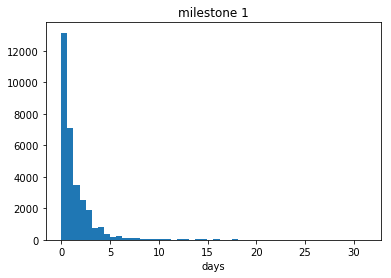

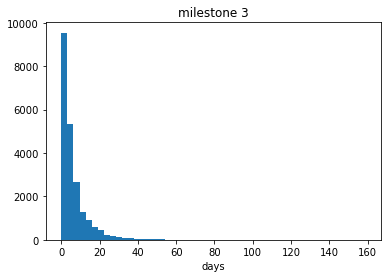

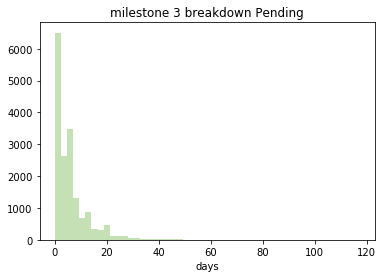

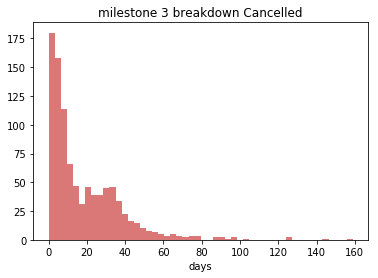

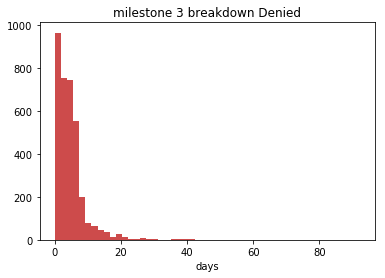

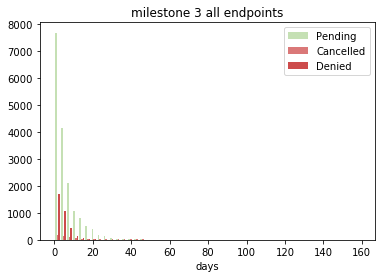

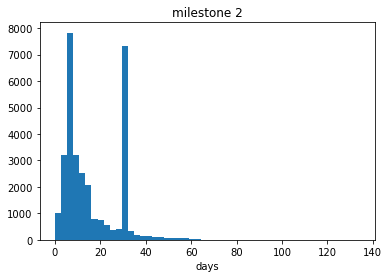

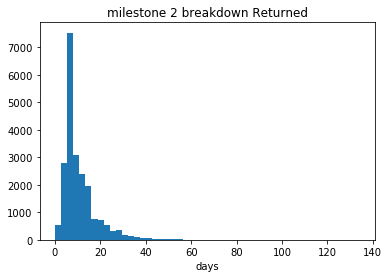

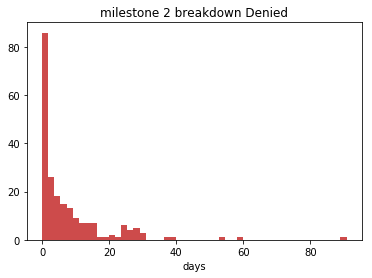

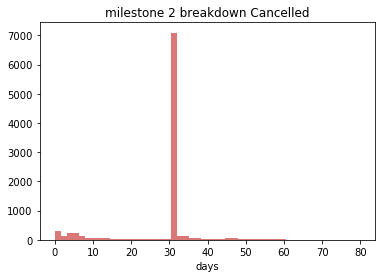

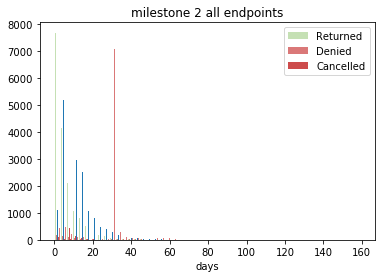

In [12]:
#3 PLOT
rgb = {'Pending': '#c5e0b4','Cancelled': '#da7878','Denied': '#cd4b4b'}
Y = []
C = []
for key, milestonedf in milestonesdict.iteritems():
    
    x =  pd.to_timedelta(milestonedf['Delta']) / np.timedelta64(1, 's')
    x =  util.seconds2hours(x)
    x =  x / 24


    plt.title(key)
    plt.xlabel('days')    
    plt.hist(x, bins=50)
    plt.savefig("throughput_analysis_2_" + key.lower() + ".eps", format='eps', dpi=1000)
    plt.show()

    endpoints = milestonedf['Endpoint'].unique()    
    
    if set(endpoints).intersection(set(['Pending','Denied','Cancelled'])):
        for pnt in endpoints:
            mask = milestonedf['Endpoint'] == pnt
            y = x[mask]
            
            Y.append(y)            
            c = rgb[pnt] if rgb.has_key(pnt) else '#1f77b4'
            C.append(c)            
            title = key + " breakdown " + pnt
            plt.title(title)
            plt.xlabel('days')
            plt.hist(y, bins=50, color=c)                
#             plt.savefig("throughput_analysis_2_" + "_".join(title.split(' ')).lower() + ".eps", format='eps', dpi=1000)
            plt.show()
        title = key + " all endpoints"    
        plt.title(title)
        plt.xlabel('days')
        plt.hist(Y, bins=50, color=C)                
        plt.legend( tuple(endpoints) )
#         plt.savefig("throughput_analysis_2_" + "_".join(title.split(' ')).lower() + ".eps", format='eps', dpi=1000)
        plt.show()
        
            

In [6]:
#4 Summarize
tables = []
for key, milestonedf in milestonesdict.iteritems():
    pivotdf = milestonedf
    pivotdf['Delta'] = pivotdf['Delta'].dt.total_seconds() / (24*3600)

    milestonetables = []
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=len)     )
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.sum)  )
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.mean) )
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.std)  )
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.min )  )
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.median ))
    milestonetables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.max) )


    tables += milestonetables
    tabledf = pd.concat(milestonetables, axis=0)
    tabledf['Endpoint'] = ['Total Applications', 'Total Days', 'Average', 'Std', 'Min', 'Median', 'Max']
    tabledf = tabledf.loc[:,['Endpoint','Pending','Denied','Cancelled']]
    

    print key
    print tabledf

tabledf = pd.concat(tables, axis=0)
tabledf.to_csv('throughput_analysis_2_by_milestones.csv', sep=',')


milestone 1
Endpoint            Endpoint  Pending  Denied  Cancelled
Delta     Total Applications      NaN     NaN        NaN
Delta             Total Days      NaN     NaN        NaN
Delta                Average      NaN     NaN        NaN
Delta                    Std      NaN     NaN        NaN
Delta                    Min      NaN     NaN        NaN
Delta                 Median      NaN     NaN        NaN
Delta                    Max      NaN     NaN        NaN
milestone 3
Endpoint            Endpoint        Pending        Denied     Cancelled
Delta     Total Applications   17227.000000   3536.000000    959.000000
Delta             Total Days  102813.279549  16513.580640  17427.828977
Delta                Average       5.968148      4.670130     18.172919
Delta                    Std       6.976872      5.298195     19.105606
Delta                    Min       0.000146      0.000102      0.001033
Delta                 Median       4.066067      3.883872     10.965691
Delta           